In [1]:
# Tools
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from IPython.display import Image
 

from ipywidgets import Layout

# Import model and  sklearn tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Load regression model trained on each dataset (RandomForestRegressor)
ideal_model = pickle.load(open("ideal_model.pkl", "rb"))

# Load cross-validation socres
cv_scores = pickle.load(open('show_scores', 'rb'))

# Read in master csv file containing all datasets
df = pd.read_csv("data/master.csv")

In [2]:
# Preprocess the user entered data
def preprocess_data(df):
    df["year"] = df.year.dt.year
    
    # Turn all of the string values into category values
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()

    # Turn categorical variables into numbers
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

# Predicting the Sale Price of a Used Car Using Machine Learning 🚘 

This notebook is a machine learning project with the goal of predicting the sale price of a used car in the UK. 
I created this notebook as a side project to learn more about regression models when predicting a quantity using time series data with the year feature 
converted as  a datetime object.


### Making Real-time Predictions

Please select from the options below and click predict to see the predicted price of your selected vehicle.

In [3]:
make_list = ['Please choose', 'Audi', 'BMW', 'Toyota', 'Ford']
audi = [(' A1'),(' A2'),(' A3'), (' A4'), (' A5'),(' A6'), (' A7'), (' A8'),
              (' Q2'), (' Q3'), (' Q5'), (' Q7'), (' Q8'), 
              (' RS3'), (' RS4'), (' RS5'), (' RS6'), (' RS7'), (' R8'),
              (' S3'), (' S4'),(' S5'), (' SQ5'), (' SQ7'), (' S8'), (' TT')]
bmw = [(' 1 Series'), (' 2 Series'), (' 3 Series'), (' 4 Series'), ( ' 5 Series'), (' 6 Series'), (' 7 Series'), (' 8 Series'),
             (' X1'), (' X2'), (' X3'), (' X4'), (' X5'), (' X6'), (' X7'),
             (' M2'), (' M3'), (' M4'), (' M5'), (' M6'), 
             (' i3'), (' i8'), (' Z3'), (' Z4')]
toyota = [(' GT86'), (' Corolla'), (' RAV4'), (' Yaris'), (' Auris'), (' Aygo'), (' C-HR'), (' Prius'),
 (' Avensis'), (' Verso'), (' Hilux'), (' PROACE VERSO'), (' Land Cruiser'), (' Supra'),
 (' Camry'), (' Verso-S'), (' IQ'), (' Urban Cruiser')]
ford = [(' Fiesta'), (' Focus'), (' Puma'), (' Kuga'), (' EcoSport'), (' C-MAX'), (' Mondeo'), (' Ka+'),
 (' Tourneo Custom'), (' S-MAX'), (' B-MAX'), (' Edge'), (' Tourneo Connect'),
 (' Grand C-MAX'), (' KA' ' Galaxy'), (' Mustang'), (' Grand Tourneo Connect'),
 (' Fusion' ' Ranger'), (' Streetka'), (' Escort'), (' Transit Tourneo')]
pc = ['Please choose']

def dropdown_eventhandler(change):
    determine(make_dropdown.value)
    # Return make specific df

def determine(x):
    if x == 'Please choose':
        model_dropdown.options = pc
    elif x == 'Audi':
        model_dropdown.options = audi
    elif x == 'BMW':
        model_dropdown.options = bmw
    elif x == 'Toyota':
        model_dropdown.options = toyota
    else:
        model_dropdown.options = ford
        

make_dropdown = widgets.Dropdown(description="Make:", options=make_list)
model_dropdown = widgets.Dropdown(description="Model:")
make_dropdown.observe(dropdown_eventhandler, names='value')

In [4]:
# GUI Widgets

# Year widget 
year =widgets.BoundedIntText(
    value=2022,
    min=1996,
    max=2022,
    step=1,
    description='Year:')

# Transmission
transmission = widgets.Dropdown(
    options=[('Automatic'), ('Semi-Auto'), ('Manual')],
    value = 'Automatic',
    description = 'Transmission:',
    disabled = False)

# Mileage 
mileage = widgets.BoundedIntText(
    value=50000,
    min=50,
    max=323000,
    step=1,
    description='Mileage:',
    disabled=False)

# Fuel type 
fuel_type = widgets.Dropdown(
    options=[('Diesel'), ('Petrol'), ('Other'), ('Hybrid'), ('Electric')],
    value = 'Petrol',
    description = 'Fuel Type',
    disabled = False)

# Tax widget
tax = widgets.BoundedIntText(
    value=130,
    min= 0,
    max= 580,
    step=1,
    description='Tax:',
    disabled=False)

# Miles per gallon
mpg = widgets.BoundedFloatText(
    value=50,
    min= 2.8,
    max= 471,
    step=1,
    description='MPG:',
    disabled=False)

# Engine size
engine_size = widgets.BoundedFloatText(
    value= 2.0,
    min= 0,
    max= 6.6,
    step=1,
    description='Engine Size:',
    disabled=False)

out = widgets.Output(layout={'border': '1px solid black'})

# Predict Button
predict = widgets.Button(
    description='Predict',
    disabled = False,
    layout=widgets.Layout(width="200", object_position= 'right bottom',height="100"),
    button_style='primary'
    )

# Handle predict button
def predict_click(b):
    out.clear_output()
    # Loaded random forest regression model
    ideal_model = pickle.load(open("ideal_model.pkl", "rb"))
    
    # declare input values
    input_make = make_dropdown.value
    input_model = model_dropdown.value
    input_year = year.value
    input_transmission = transmission.value
    input_mileage = mileage.value
    input_fuel_type = fuel_type.value
    input_tax = tax.value
    input_mpg = mpg.value
    input_engine_size = engine_size.value
    
    # Create dataframe from user's selections
    new_df = pd.DataFrame({'make': [input_make], 'model': [input_model], 'year': [input_year], 'transmission': [input_transmission],
                          'mileage': [input_mileage], 'fuelType': [input_fuel_type], 'tax': [input_tax], 'mpg': [input_mpg], 
                           'engineSize': [input_engine_size]})
    new_df['year'] = pd.to_datetime(new_df['year'])
    processed_df = preprocess_data(new_df)
    
    # Make prediction
    pred = ideal_model.predict(processed_df)
    
    # Format prediction
    df_pred = pd.DataFrame()
    df_pred['price'] = pred
    prediction = df_pred.loc[0][0]

    with out:
        print("The predicted sale price of your vehicle is: $", format(prediction, ".2f" ))
        
        
predict.on_click(predict_click)   

# Reset Button
reset = widgets.Button(
    description='Reset',
    disabled = False,
    layout=widgets.Layout(width="200", object_position= 'right bottom',height="100"),
    button_style='primary'
    )

# Handle reset button
def reset_click(b):
    # clear output
    out.clear_output()
    
    # Reset values to default
    make_dropdown.value = 'Please choose'
    model_dropdown.value = None
    year.value = 2022
    transmission.value = 'Automatic'
    mileage.value = 50000
    fuel_type.value = 'Petrol'
    tax.value = 130
    mpg.value = 50
    engine_size.value = 2.0

reset.on_click(reset_click)
    


In [5]:
# Box containing buttons
buttons = [reset, predict]
button_box = widgets.HBox(buttons, layout=widgets.Layout(width='550px', align_items='center'))

# Box containing widgets

widget_box = [make_dropdown, model_dropdown,fuel_type, mpg, engine_size, year, mileage, tax, transmission]
wb_box = widgets.GridBox(widget_box, layout=widgets.Layout(grid_template_columns="repeat(3, 2, 350px)"))
ui_parts = [wb_box, button_box, out]
ui = widgets.VBox(ui_parts)

In [6]:
ui

## 1. Problem Definition

How well can we predict the future sale price of a used vehicle given its characteristics and previous examples of how much 
similar used cars have sold for?

## 2. Data

The data is downloaded from Kaggle at the following link: https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes
        
Note: This dataset has been obtained from the UK. The predict method would not be accurate of used vehicles within the United States.
    
    
There are four datasets the model was trained on and tested with:
    
* audi.csv contains data on used Audi vehicles. 
* bmw.csv contains data on used BMW vehicles. 
* toyota.csv contains data on used Toyota vehicles. 
* ford.csv contains data on used Ford vehicles. 

The master.csv file is comprised of these four data sets with a "make" column added to distinguish the vehicles make as a feature.
No other feature engineering is noted.


In [7]:
# Functions for descriptive visuals

# Scatter plot describing year/price
def scatter_plot(df):
    fig, ax = plt.subplots()
    ax.scatter(df["year"][:1000], df["price"][:1000])
    
# Price histogram   
def price_plot(df):
    df.price.plot.hist()

## 3. Evaluation

The evaluation metric for this project is the RMSLE(root mean squared log error) between the actual and predicted used car
sale prices.

Simplified, the goal is to minimize prediction errors.

## 4. Features
* Make
* Model
* Year
* Transmission
* Fuel type
* Tax
* MPG
* Engine size

### Simplified View

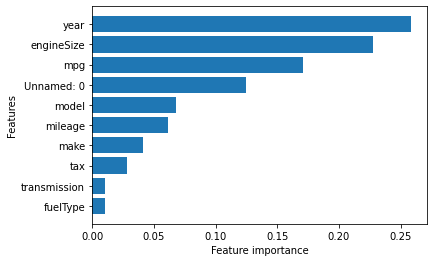

In [8]:
Image(filename='images/feature_importance.png')

### Relationship between input and output - A deeper look

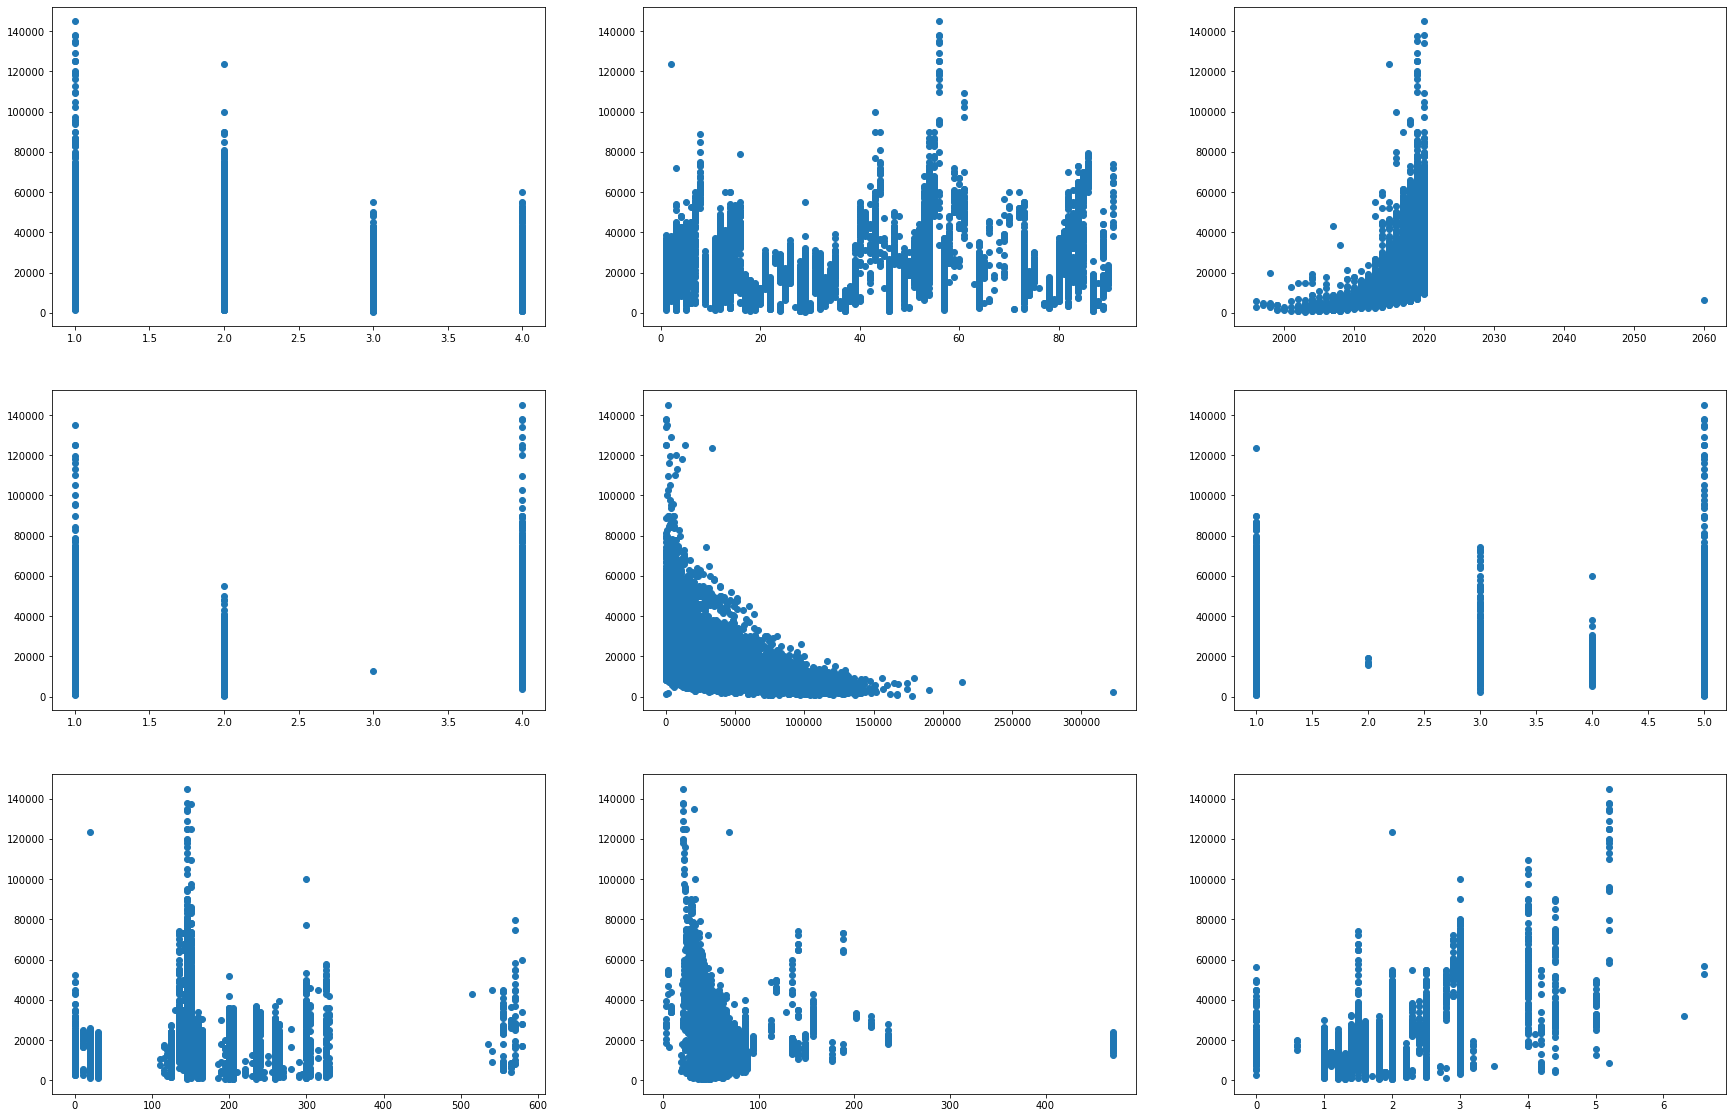

In [9]:
Image(filename='images/input_output_relationship.png')

## 5. Modelling

A Random Forest Regression model was used to train the data.

To find out more about Random Forest Regression click here:
https://www.askpython.com/python/examples/random-forest-regression
    

### Cross-Validation Scores

In [10]:
cv_scores

{'Training MAE': 900.1715187801835,
 'Test MAE': 1171.20809488802,
 'Training RMSLE': 0.07756558813078307,
 'Test RMSLE': 0.10309054329424935,
 'Training R^2': 0.9773507602618778,
 'Test R^2': 0.9644690670642001}